In [341]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Compose, Scale
import os
import numpy as np
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [342]:
def is_image_file(filename):
    return any(filename.endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])

def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    basename = os.path.basename(filepath)
    label = os.path.splitext(basename)[0]
    return img, label
    
class ImgDataSet(Dataset):
    
    def __init__(self, img_dir, input_transform=None, target_transform=None):
        super(ImgDataSet, self).__init__()
        self.image_filenames = [os.path.join(img_dir, x) for x in os.listdir(img_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform
    
    def __getitem__(self, index):
        img, label = load_img(self.image_filenames[index])
        if self.input_transform is not None:
            img = self.input_transform(img)
            #print(img.size())
        if self.target_transform is not None:
            label = self.target_transform(label)
        label = np.asarray(list(map(int, list(label))))
        return img, torch.from_numpy(label)
    
    def __len__(self):
        return len(self.image_filenames)

In [343]:
# loading image data, 
batch_size = 32
transform_fn = Compose([Scale(24), ToTensor()])
train_set = ImgDataSet(img_dir='/Users/smart/data/ocr/train', input_transform=transform_fn)
val_set = ImgDataSet(img_dir='/Users/smart/data/ocr/val', input_transform=transform_fn)
train_set_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=batch_size, shuffle=True)
val_set_loader = DataLoader(dataset=val_set, num_workers=2, batch_size=len(val_set), shuffle=True)
val_iter = iter(val_set_loader)

In [344]:
# building model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=(1,1), padding=(2,2)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, (5, 5), stride=(1,1), padding=(2,2)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, (3, 3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, (3, 3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Linear(192, 10)
        self.fc2 = nn.Linear(192, 10)
        self.fc3 = nn.Linear(192, 10)
        self.fc4 = nn.Linear(192, 10)
        self.fc5 = nn.Linear(192, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x1 = F.log_softmax(self.fc1(x)).unsqueeze(1)
        x2 = F.log_softmax(self.fc2(x)).unsqueeze(1)
        x3 = F.log_softmax(self.fc3(x)).unsqueeze(1)
        x4 = F.log_softmax(self.fc4(x)).unsqueeze(1)
        x5 = F.log_softmax(self.fc5(x)).unsqueeze(1)
        return torch.cat([x1, x2, x3, x4, x5], 1)

In [345]:
model = Net()
cuda = torch.cuda.is_available()
criterion = nn.loss.NLLLoss()
if cuda:
    model = model.cuda()
    loss = loss.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

In [346]:
def Accuracy(predict, target):
    predict = predict.view(-1, 10)
    target = target.view(-1)
    label = torch.topk(predict, 1)[1]
    label = label.data.squeeze().tolist()
    target = target.tolist()
    acc = 1.0 * np.sum(np.equal(label, target)) / len(target)
    print(target)
    print(label)
    print(acc)
    return acc

In [347]:
def test():
    # eval val datasets after each epoch
    try:
        x_val, y_val = val_iter.next()
    except:
        val_iter = iter(val_set_loader)
        x_val, y_val = val_iter.next()
    y_predict = model(Variable(x_val))
    acc = Accuracy(y_predict, y_val)
    acc_record.append(acc)
    print('=====> Epoch [{}] : Accuracy: {:.4f}'.format(epoch, acc))

In [348]:
epoches = 5
loss_record = []
acc_record = []
for epoch in range(epoches):
    for iteration, batch in enumerate(train_set_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1])
        #print(input.size())
        if cuda:
            input, target = input.cuda(), target.cuda()
        optimizer.zero_grad()
        #print(input.size())
        predict = model(input)
        predict = predict.view(-1, 10)
        target = target.view(-1)
        
        loss = criterion(predict, target.squeeze(0))
        loss_record.append(loss.data.tolist())
        loss.backward()
        optimizer.step()
        print('=====> Epoch[{}]({}/{}): Loss: {:.4f}'.format(epoch, iteration, len(train_set_loader), loss.data[0]))
        
        if iteration % 10 == 0:
            test()

=====> Epoch[0](1/88): Loss: 2.2852
=====> Epoch[0](2/88): Loss: 2.2932
=====> Epoch[0](3/88): Loss: 2.2411
=====> Epoch[0](4/88): Loss: 2.2073
=====> Epoch[0](5/88): Loss: 2.1663
=====> Epoch[0](6/88): Loss: 2.1305
=====> Epoch[0](7/88): Loss: 2.1453
=====> Epoch[0](8/88): Loss: 2.0791
=====> Epoch[0](9/88): Loss: 2.0550
=====> Epoch[0](10/88): Loss: 2.0644
[2, 2, 6, 5, 6, 2, 6, 3, 9, 8, 2, 8, 4, 4, 5, 2, 2, 3, 5, 2, 2, 8, 4, 8, 3, 2, 2, 6, 6, 8, 2, 4, 4, 8, 6, 2, 2, 6, 4, 9, 2, 2, 5, 6, 2, 2, 8, 4, 9, 6, 2, 2, 6, 5, 2, 2, 8, 5, 2, 2, 2, 2, 5, 9, 6, 2, 2, 6, 5, 3, 2, 2, 5, 8, 9, 2, 6, 6, 2, 2, 2, 8, 4, 5, 4, 2, 6, 3, 2, 4, 2, 2, 5, 2, 2, 2, 8, 4, 4, 4, 2, 8, 4, 5, 3, 2, 6, 4, 5, 6, 2, 8, 4, 6, 8, 2, 2, 4, 4, 6, 2, 4, 5, 3, 2, 2, 4, 5, 8, 9, 2, 4, 3, 6, 6, 2, 8, 4, 4, 6, 2, 2, 6, 3, 8, 2, 6, 5, 5, 3, 2, 4, 4, 4, 6, 2, 2, 6, 6, 6]
[6, 9, 2, 4, 3, 4, 9, 5, 4, 3, 6, 9, 8, 4, 5, 6, 9, 8, 4, 4, 6, 6, 9, 4, 3, 6, 9, 8, 4, 3, 6, 9, 8, 4, 8, 5, 9, 8, 4, 4, 5, 2, 8, 4, 5, 6, 9, 8, 4, 3, 5, 9, 9

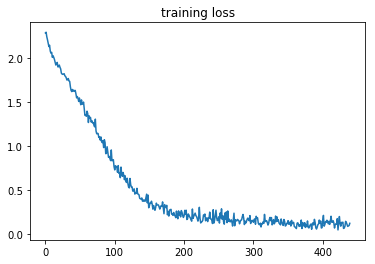

In [349]:
plt.figure()
loss_record = np.asarray(loss_record).ravel()
plt.plot(loss_record)
plt.title('training loss')

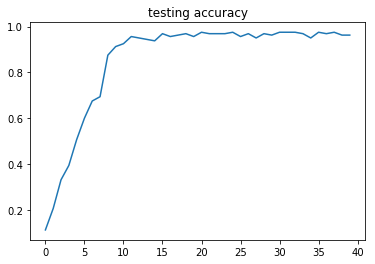

In [350]:
plt.figure()
acc_record = np.asarray(acc_record).ravel()
plt.plot(acc_record)
plt.title('testing accuracy')

In [351]:
def inference(filepath):
    img_test = load_img(filepath)
    img = np.asarray(img_test[0])
    input = transform_fn(img_test[0])
    input = Variable(input)
    input = input.unsqueeze(0)
    #print(input.size())
    predict = model(input)
    #print(predict.size())
    result = torch.topk(predict, 1, 2)
    return img, result
    

/Users/smart/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


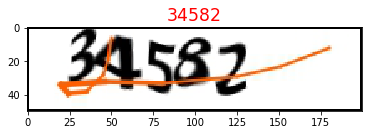

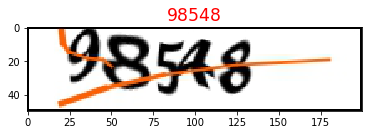

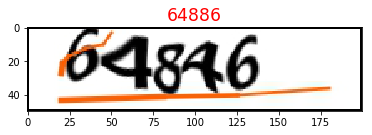

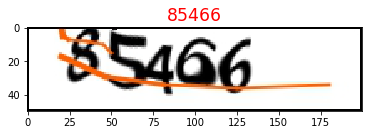

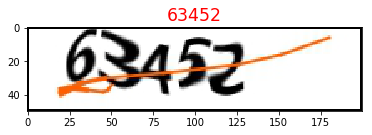

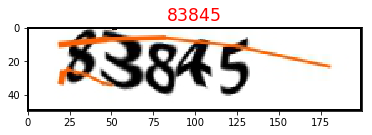

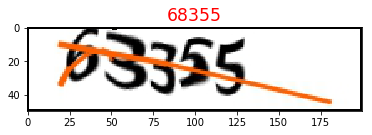

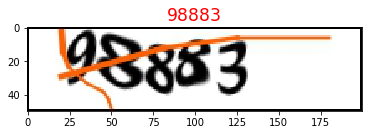

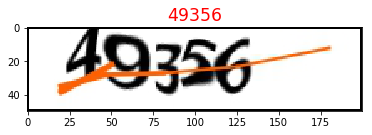

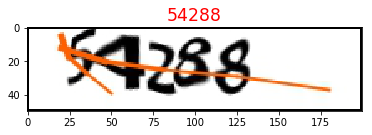

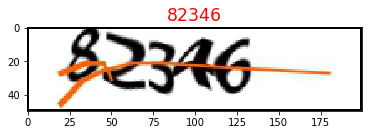

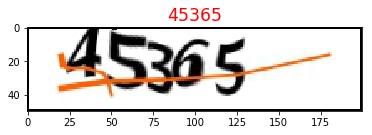

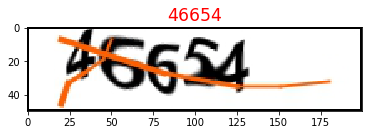

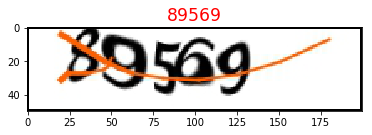

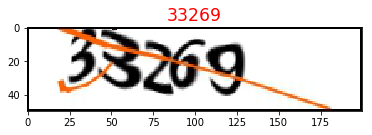

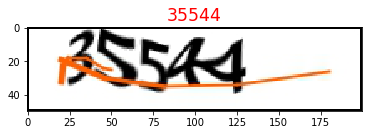

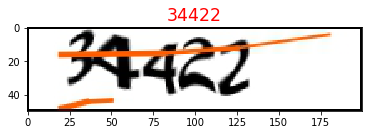

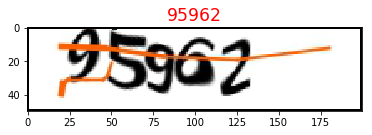

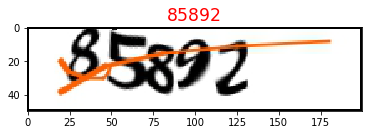

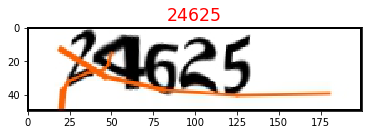

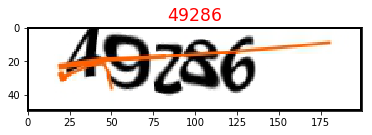

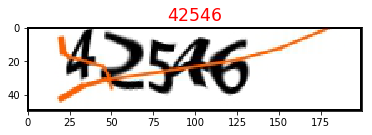

In [352]:
import glob
test_list = glob.glob('/Users/smart/data/ocr/test/*.jpg') 
for file in test_list:
    img, label = inference(file)
    label_str = ''.join(map(str, label[1].data.squeeze().tolist()))
    plt.figure()
    plt.title(label_str, color='red', size='xx-large')
    plt.imshow(img)